In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display
import skimage.segmentation as seg
import skimage.color as color
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.util import img_as_float

import skimage
from skimage import io
from skimage.color import rgb2gray
import skimage.segmentation as seg
from scipy import ndimage
import skimage.morphology as morph
from skimage.feature import peak_local_max
from skimage import filters
from skimage.morphology import disk, ball
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.segmentation import flood, flood_fill
from PIL import Image, ImageDraw, ImageFilter
import copy
import cv2


In [2]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1=io.imread(path+'/'+grain1_name).astype('uint8')
grain2=io.imread(path+'/'+grain2_name).astype('uint8')
grain3=io.imread(path+'/'+grain3_name).astype('uint8')

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

In [3]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

In [4]:
def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])
 

In [5]:
def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

In [6]:
def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=skimage.filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global
    

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [7]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

In [8]:
denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

In [9]:
denoised3

array([[185, 185, 185, ..., 157, 151, 137],
       [181, 187, 187, ..., 160, 151, 149],
       [185, 185, 185, ..., 160, 152, 149],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

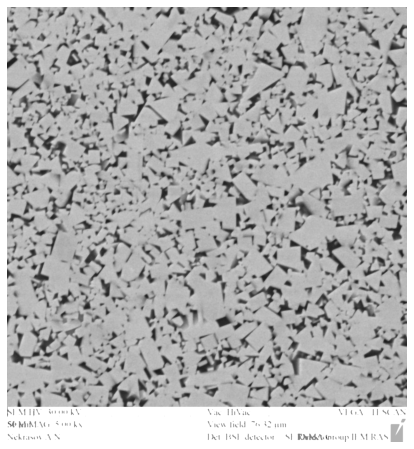

In [10]:
img_show(denoised3,N=8,cmap='gray')

In [11]:
binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


In [12]:
binary3

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

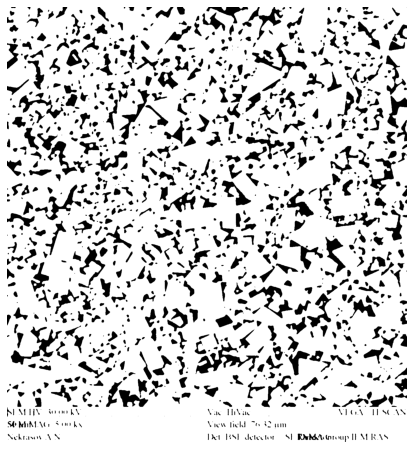

In [13]:
img_show(binary3,N=8,cmap='gray')

In [14]:
grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

In [15]:
grad3

array([[0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

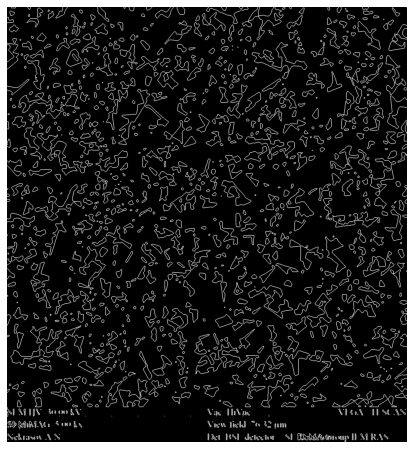

In [16]:
img_show(grad3,N=8,cmap='gray')

In [17]:
bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

In [18]:
bin_grad3

array([[0, 0, 0, ..., 0, 1, 2],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

у зерен значение пикселя - 0, у тела пустоты - 1, у границы пустоты - 2

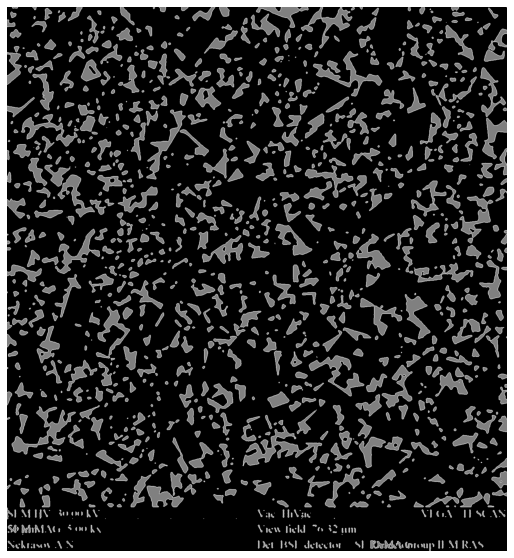

In [19]:
img_show(bin_grad3,N=10,cmap='gray')

## Save

In [20]:
image=127*bin_grad2
#io.imsave('bin_grad.png',image)

In [21]:
#image=grain2_marked
#io.imsave('corners2.png',image)

## Маркировка углов

In [22]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 10000, 0.1, 12)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    del x
    del y
    return image,corners

In [23]:
grain1_marked,grain1_corners=mark_corners(bin_grad1*127)
grain2_marked,grain2_corners=mark_corners(bin_grad2*127)
grain3_marked,grain3_corners=mark_corners(bin_grad3*127)

number of corners:  244
number of corners:  1244
number of corners:  3619


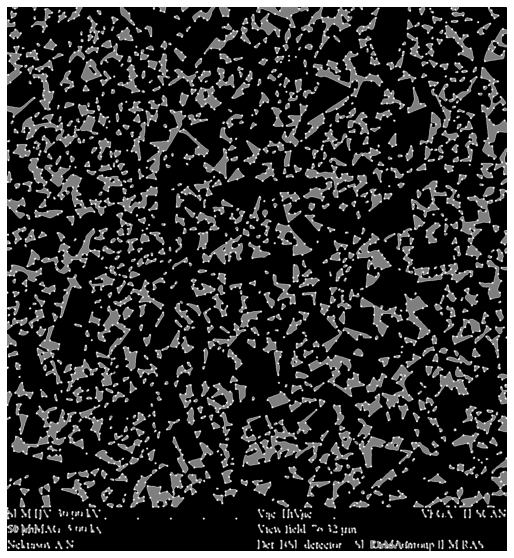

In [24]:
img_show(grain3_marked, N=10,cmap='gray')

classes - каждому пикселю дается свой класс, по картинке гуляет матрица свертки

In [25]:
def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num

In [26]:
grain1_classes,class1_num=mark_classes(bin_grad1*127)
grain2_classes,class2_num=mark_classes(bin_grad2*127)
grain3_classes,class3_num=mark_classes(bin_grad3*127)

number of classes: 184
number of classes: 337
number of classes: 1218


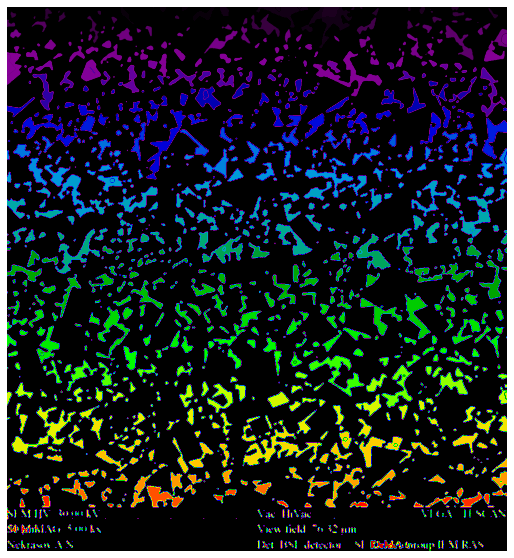

In [27]:
img_show(grain3_classes, N=10)

## Отметим наличие углов для каждого класса пустоты

In [28]:

shape=(class2_num+1,200)
classes=grain2_classes
corners=grain2_corners
nodes=np.zeros(shape)

num1=0
num0=0
r=2
for i,corner in enumerate(corners):
    x=corner[0][0]
    y=corner[0][1]
    cls=classes[x,y]
    real_cls=0
    flag=True
    while flag:
        for xi in range(x-r,x+r):
            for yi in range(y-r,y+r):
                if classes[xi,yi]!=0 and classes[xi,yi]!=1:
                    real_cls=classes[xi,yi]
                    flag=False
    if real_cls==1:
        num1+=1
    elif real_cls==0:
        num0+=1
    else:
        index=np.where(nodes[real_cls]==0)[0][0]
        nodes[real_cls,index]=i


print('class 0 number',num0)
print('class 1 number',num1)

class 0 number 0
class 1 number 0


## Визуализируем графы каждой пустоты

In [29]:
test_image=Image.open('bin_grad.png')
draw = ImageDraw.Draw(test_image)

In [30]:
for node in nodes[2:].astype('int64'):
    indeces=[]
    for index in node:
        if index!=0:
            indeces.append(index)
    cls_corners=corners[indeces]
    for corner1 in cls_corners:
        for corner2 in cls_corners:
            x1=corner1[0][0]
            y1=corner1[0][1]
            x2=corner2[0][0]
            y2=corner2[0][1]
            draw.line((y1,x1,y2,x2), fill=(185), width=1)
                
test_image.save('edge.jpg')

## Подсчитаем количество углов у пустот

In [31]:
node_corner_numbers=np.zeros((classes.shape[0],1))
for i,node in enumerate(nodes):
    num=0
    for corner in node:
        if corner:
            num+=1
 #   print(num)
    node_corner_numbers[i]=num

In [32]:
std=node_corner_numbers.std(axis=0)[0]
mean=node_corner_numbers.mean(axis=0)[0]
print('std=',std)
print('mean',mean)

std= 2.2694566856625458
mean 0.743865948533812


In [33]:
node_corner_numbers.sum(axis=0)

array([1243.])

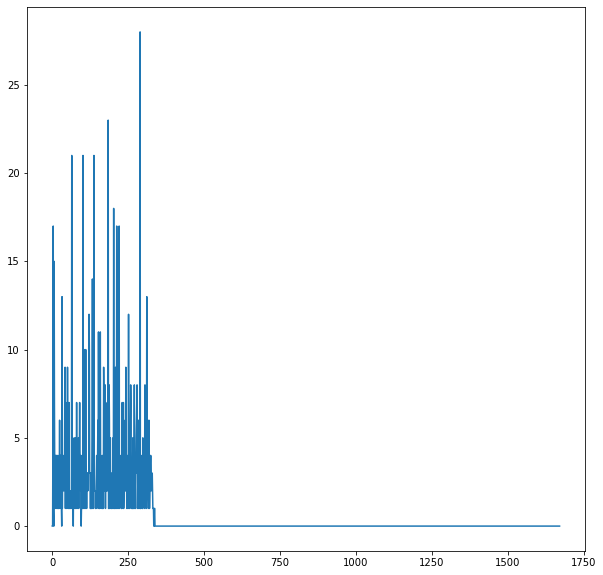

In [34]:
plt.figure(figsize=(10,10))
plt.plot(node_corner_numbers)

## Подсчитаем количество пустот, в которое входит угол

In [35]:
corner_distr=np.zeros((corners.shape[0]))
for i in range(corners.shape[0]):
    for node in nodes:
        if i in node:
            corner_distr[i]+=1

In [36]:
corner_distr

array([338.,   1.,   1., ...,   1.,   1.,   1.])

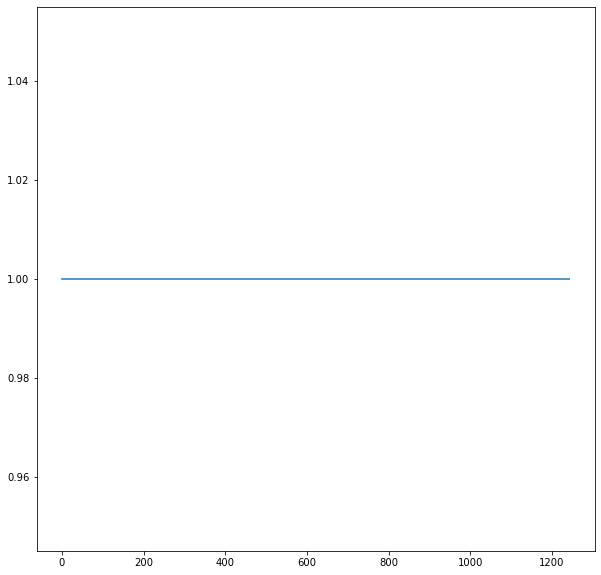

In [37]:
plt.figure(figsize=(10,10))
plt.plot(corner_distr[1:])

## Соединим углы пустоты по периметру

In [57]:
x_lin.shape

(771,)

In [58]:
y_lin.shape

(771,)

In [59]:
x_lin.max()

1603

In [61]:
y_lin.max()

777

In [67]:
def mean_pixel(image,point1,point2,r):
    val=0
    num=0
    image=rgb2gray(image)
    x1,y1=point1[0],point1[1]
    x2,y2=point2[0],point2[1]

    # идем всегда из х1 в х2, сверху вниз
    if x1>x2:
        x1,y1,x2,y2=x2,y2,x1,y1

    y_lin=[]
    x_lin=range(x1,x2)
    # проведем линию и сохраним ее координаты
    for xi in x_lin:
        y_lin.append(round(((xi-x1)/(x2-x1))*(y2-y1)+y1))
    # координатная ось повернута на -90 градусов
    # новый х=-y, новый y=x

    x_lin=np.array(x_lin,dtype='int64')
    y_lin=np.array(y_lin,dtype='int64')
    for xi,yi in zip(y_lin,x_lin):

        for x in range(xi-r,xi+r):
            for y in range(yi-r,yi+r):

                val+=image[y,x]
                num+=1

    return val/num

In [74]:
#point1=corners[0][0]
#point2=corners[1][0]
point1=(540,239)
point2=(595,265)
print(point1)
print(point2)

(540, 239)
(595, 265)


In [75]:
mean_pixel(bin_grad2,point1,point2,2)

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


0.46704545454545454

In [ ]:
img_show(test_image,cmap='gray')